In [1]:
import pyBigWig
import pandas as pd
import numpy as np
from multiprocessing import Process, Value, Array, Pool
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import repeat
import os
import glob
import pickle
from collections import OrderedDict

%load_ext lab_black

In [2]:
def save_object(obj, filename):
    with open(filename, "wb") as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


# sample usage
# save_object(company1, 'company1.pkl')

In [3]:
bw_path_dict = OrderedDict(
    {
        x.split("/")[-1].split(".")[0]: x
        for x in glob.glob(
            "per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/*.bw"
        )
    }
)
bw_path_dict

OrderedDict([('10xv2',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv2.bw'),
             ('ddseq',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/ddseq.bw'),
             ('10xmultiome',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xmultiome.bw'),
             ('mtscatac',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/mtscatac.bw'),
             ('s3atac',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/s3atac.bw'),
             ('10xv11',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv11.bw'),
             ('10xv1',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv1.bw'),
             ('hydrop',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/hydrop.bw')])

In [4]:
bed_path_dict = {
    x.split("/")[-1].split("__")[1]: x
    for x in glob.glob("downstream_analysis/DARs/master_sub_1.FIXEDCELLS/*TOP2k.bed")
}
bed_path_dict

{'Cytotoxic_T_cell': 'downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed',
 'CD14+_monocyte': 'downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD14+_monocyte__DARs.TOP2k.bed',
 'B_cell': 'downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__B_cell__DARs.TOP2k.bed',
 'CD16+_monocyte': 'downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD16+_monocyte__DARs.TOP2k.bed',
 'Dendritic_cell': 'downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Dendritic_cell__DARs.TOP2k.bed',
 'Natural_killer_cell': 'downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed',
 'CD4+_T_cell': 'downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD4+_T_cell__DARs.TOP2k.bed'}

In [5]:
tech_alias_dict = {
    "10xmultiome": "10x Multiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv2": "10x v2",
    "ddseq": "ddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "s3atac": "s3-ATAC",
}

tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

tech_order = [
    "10xv1",
    "10xv11",
    "10xv2",
    "10xmultiome",
    "mtscatac",
    "ddseq",
    "s3atac",
    "hydrop",
]

cell_type_alias_dict = {
    "B_cell": "B cells",
    "CD14+_monocyte": "CD14+ monocytes",
    "CD4+_T_cell": "CD4+ T cells",
    "Cytotoxic_T_cell": "CD8+ T cells",
    "Dendritic_cell": "Dendritic cells",
    "Natural_killer_cell": "NK cells",
    "CD16+_monocyte": "CD16+ monocytes",
}

cell_type_order = [
    "B_cell",
    "CD14+_monocyte",
    "CD4+_T_cell",
    "Cytotoxic_T_cell",
    "Dendritic_cell",
    "Natural_killer_cell",
    "CD16+_monocyte",
]

cell_type_color_dict = {
    "B_cell": "#88CCEE",
    "CD14+_monocyte": "#CC6677",
    "CD4+_T_cell": "#DDCC77",
    "Cytotoxic_T_cell": "#117733",
    "Dendritic_cell": "#332288",
    "Natural_killer_cell": "#AA4499",
    "CD16+_monocyte": "#44AA99",
}

# generate count matrices of bigwigs in beds

In [54]:
def read_bw_values(bed_part, bw):
    bw = pyBigWig.open(bw)
    colnames = np.append(
        np.arange(-1250, 0), np.arange(0, 1250)
    )  # colnames are a range over the interval that we look at
    df = pd.DataFrame(columns=colnames)
    for line in bed_part.iterrows():
        vals = bw.values(
            line[1][0],
            int(line[1][1]) - interval_downstream,
            int(line[1][2]) + interval_upstream,
        )
        df.loc[line[0]] = vals

    return df

In [55]:
max_dict = {}
interval_downstream = 1000
interval_upstream = 1000
binsize = 20
top_n = 2000
cores = 24

In [56]:
bw_path_dict

OrderedDict([('10xv2',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv2.bw'),
             ('ddseq',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/ddseq.bw'),
             ('10xmultiome',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xmultiome.bw'),
             ('mtscatac',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/mtscatac.bw'),
             ('s3atac',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/s3atac.bw'),
             ('10xv11',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv11.bw'),
             ('10xv1',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv1.bw'),
             ('hydrop',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/hydrop.bw')])

In [117]:
count_mats_bool = False
if count_mats_bool == True:
    for sample in list(bed_path_dict.keys()):
        print(sample)
        print(bed_path_dict[sample])
        df_bed = pd.read_csv(bed_path_dict[sample], sep="\t", index_col=None)
        df_bed.columns = ["chr", "start", "stop", "name", "logFC", "strand", "pval"]
        # df_bed.set_index('name', inplace=True)
        # df_bed.index.name = None
        df_bed = df_bed[0:top_n]

        mat_dict = {}

        for key in bw_path_dict.keys():

            torun = np.array_split(df_bed, cores, axis=0)
            bw = bw_path_dict[key]
            print(f"\t{bw}")

            iterable = zip(
                torun, repeat(bw)
            )  # this is the KEY difference between this and previous module. we now iterate over all keys to do all bigwigs instead of keeping all bigwigs the same

            # Calculate
            pool = Pool(processes=cores)
            results = pool.starmap(read_bw_values, iterable)
            pool.close()
            pool.join()
            df = pd.concat(results)
            df_binned = df.groupby(np.arange(len(df.columns)) // binsize, axis=1).mean()
            df_binned_nonan = df_binned.fillna(0)
            order = df_binned_nonan.mean(axis=1).sort_values(
                ascending=False
            )  # now reorder based in maximum mean
            df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

            mat_dict[key] = df_binned_nonan_ordered

        save_object(
            mat_dict,
            "per_tech_bigwigs/"
            + sample
            + "_DARs_binsize"
            + str(binsize)
            + "_coveragemats_refined_logfcorder.pkl",
        )

        df_merged = pd.DataFrame(columns=range(0, len(mat_dict[key].columns)))
        for key in mat_dict.keys():
            df_merged = df_merged.append(mat_dict[key], ignore_index=False)

        quantiles = df_merged.quantile(
            q=0.99
        )  # for every base, calculate the quantile q value over all regions.
        maximum = (
            quantiles.max()
        )  # then, take the maxmum value out of these 250 values.
        print(
            maximum
        )  # the resulting maximum should give a cutoff that represents the 99th quantil of all values

        # alternatively, you can take a global quantile for the entire matrix (instead of per base)
        maximum = np.quantile(df_merged, 0.99)
        print(maximum)

        max_dict[sample] = maximum

        # f,ax = plt.subplots(1,len(sampleorder))
        # f.set_figheight(5)
        # f.set_figwidth(len(sampleorder)*3)

        # for key in sampleorder:
        #     g = sns.heatmap(mat_dict[key], cmap="viridis", cbar=False, ax=ax[sampleorder.index(key)], vmax=maximum, xticklabels=False, yticklabels=False)

        # save_object(f, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_f.pkl')
        # save_object(ax, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_ax.pkl')

    save_object(
        max_dict,
        "per_tech_bigwigs/DARs_binsize"
        + str(binsize)
        + "_max_dict_refined_logfcorder.pkl",
    )

# now plot

In [58]:
top_n = 2000

binsize = 20
filenames = sorted(
    glob.glob("per_tech_bigwigs/*" + str(binsize) + "_coveragemats_refined_logfcorder.pkl")
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_logfcorder.pkl", ""
    )
    for item in filenames
]
samples = [item.replace("per_tech_bigwigs/", "") for item in samples]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'B_cell': 'heatmap_mats/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14+_monocyte': 'heatmap_mats/CD14+_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16+_monocyte': 'heatmap_mats/CD16+_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4+_T_cell': 'heatmap_mats/CD4+_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'heatmap_mats/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'heatmap_mats/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'heatmap_mats/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

In [59]:
coveragemats_dict

{'B_cell': 'heatmap_mats/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14+_monocyte': 'heatmap_mats/CD14+_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16+_monocyte': 'heatmap_mats/CD16+_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4+_T_cell': 'heatmap_mats/CD4+_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'heatmap_mats/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'heatmap_mats/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'heatmap_mats/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

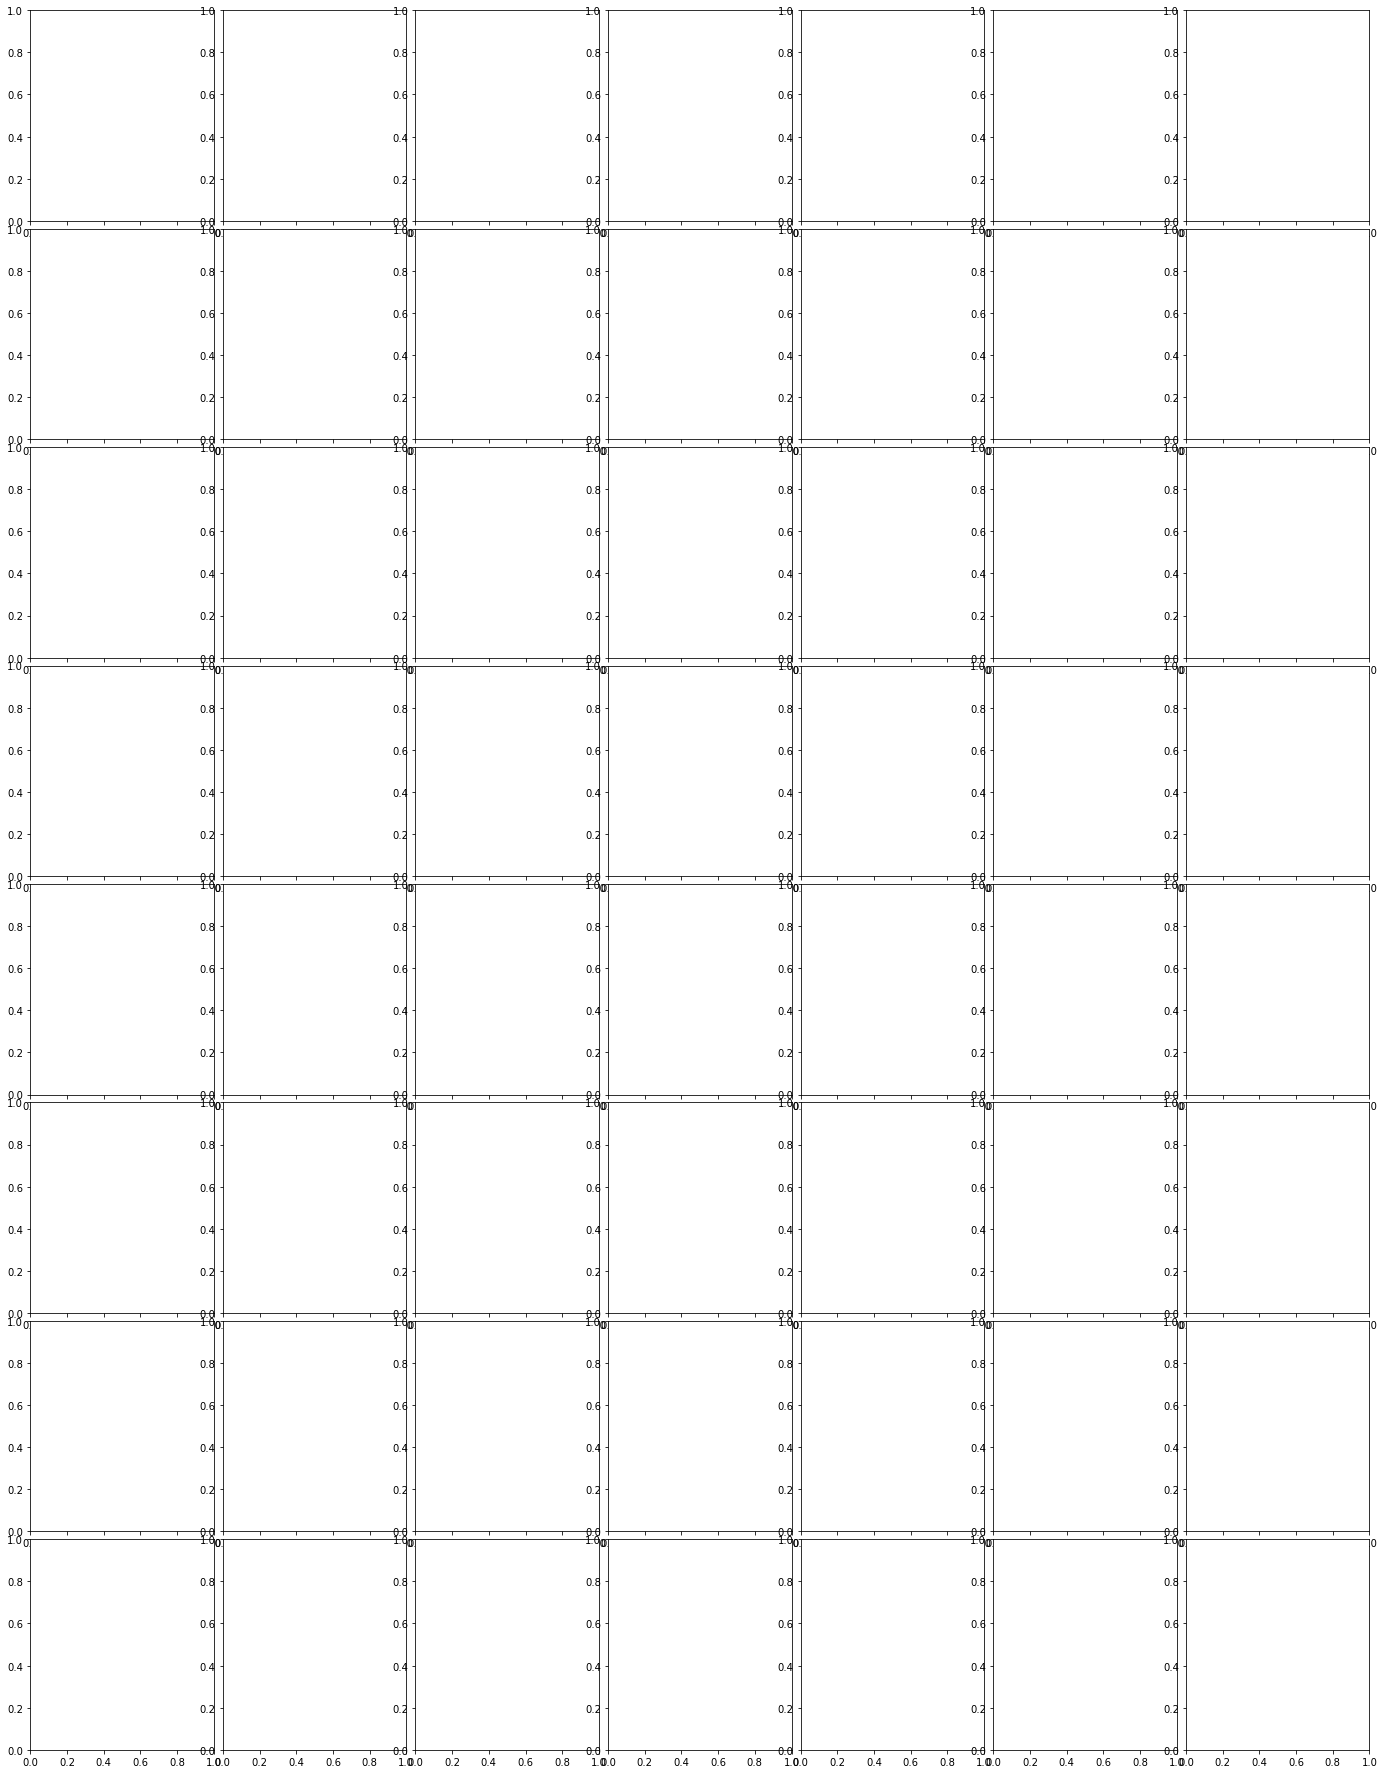

In [60]:
final_sampleorder = tech_order

height = len(final_sampleorder) * 4
width = len(final_sampleorder) * 3
figure, axes = plt.subplots(len(final_sampleorder), len(coveragemats_dict.keys()))

figure.set_figheight(height)
figure.set_figwidth(width)
figure.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05 / (4 / 3)
)

In [61]:
binsize = 20
filenames = sorted(
    glob.glob("per_tech_bigwigs/*" + str(binsize) + "_coveragemats_refined_logfcorder.pkl")
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_logfcorder.pkl", ""
    )
    for item in filenames
]
samples = [item.replace("per_tech_bigwigs/", "") for item in samples]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'B_cell': 'heatmap_mats/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14+_monocyte': 'heatmap_mats/CD14+_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16+_monocyte': 'heatmap_mats/CD16+_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4+_T_cell': 'heatmap_mats/CD4+_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'heatmap_mats/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'heatmap_mats/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'heatmap_mats/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

In [62]:
with open(
    f"heatmap_mats/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl", "rb"
) as f:
    max_dict = pickle.load(f)

mat_dict = {}
df_merged = pd.DataFrame()
for key in coveragemats_dict.keys():
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)
    for subkey in final_sampleorder:
        df_merged = df_merged.append(mat_dict[subkey], ignore_index=False)

maximum = np.quantile(df_merged, 0.99)
print(maximum)

loading B_cell...
loading CD14+_monocyte...
loading CD16+_monocyte...
loading CD4+_T_cell...
loading Cytotoxic_T_cell...
loading Dendritic_cell...
loading Natural_killer_cell...
1.3639919818043709


In [63]:
color_max = max(max_dict.values())
with open(
    f"per_tech_bigwigs/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl", "rb"
) as f:
    max_dict = pickle.load(f)

for key in coveragemats_dict.keys():
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)
    for subkey in final_sampleorder:
        g = sns.heatmap(
            mat_dict[subkey][0:top_n],
            cmap="viridis",
            cbar=False,
            ax=axes[
                final_sampleorder.index(subkey),
                list(coveragemats_dict.keys()).index(key),
            ],
            vmax=color_max,
            xticklabels=False,
            yticklabels=False,
        )

    print(f"{key} processed!")

loading B_cell...
B_cell processed!
loading CD14+_monocyte...
CD14+_monocyte processed!
loading CD16+_monocyte...
CD16+_monocyte processed!
loading CD4+_T_cell...
CD4+_T_cell processed!
loading Cytotoxic_T_cell...
Cytotoxic_T_cell processed!
loading Dendritic_cell...
Dendritic_cell processed!
loading Natural_killer_cell...
Natural_killer_cell processed!


In [ ]:
# for key in coveragemats_dict.keys():
#     axes[
#         list(coveragemats_dict.keys()).index(key),
#         list(coveragemats_dict.keys()).index(key),
#     ].patch.set_edgecolor("blue")
#     axes[
#         list(coveragemats_dict.keys()).index(key),
#         list(coveragemats_dict.keys()).index(key),
#     ].patch.set_linewidth("15")

In [64]:
for key in coveragemats_dict.keys():
    axes[0, cell_type_order.index(key)].set_title(
        f"{cell_type_alias_dict[key]}\nDARs",
        fontsize=20,
        color=cell_type_color_dict[key],
    )
    print(f"{cell_type_alias_dict[key]} DARs")

B cells DARs
CD14+ monocytes DARs
CD16+ monocytes DARs
CD4+ T cells DARs
CD8+ T cells DARs
Dendritic cells DARs
NK cells DARs


In [65]:
for key in final_sampleorder:
    axes[final_sampleorder.index(key), -1].set_ylabel(
        f"{tech_alias_dict[key]} BW",
        fontsize=20,
        color=tech_color_palette[key],
    )
    axes[final_sampleorder.index(key), -1].yaxis.set_label_position("right")

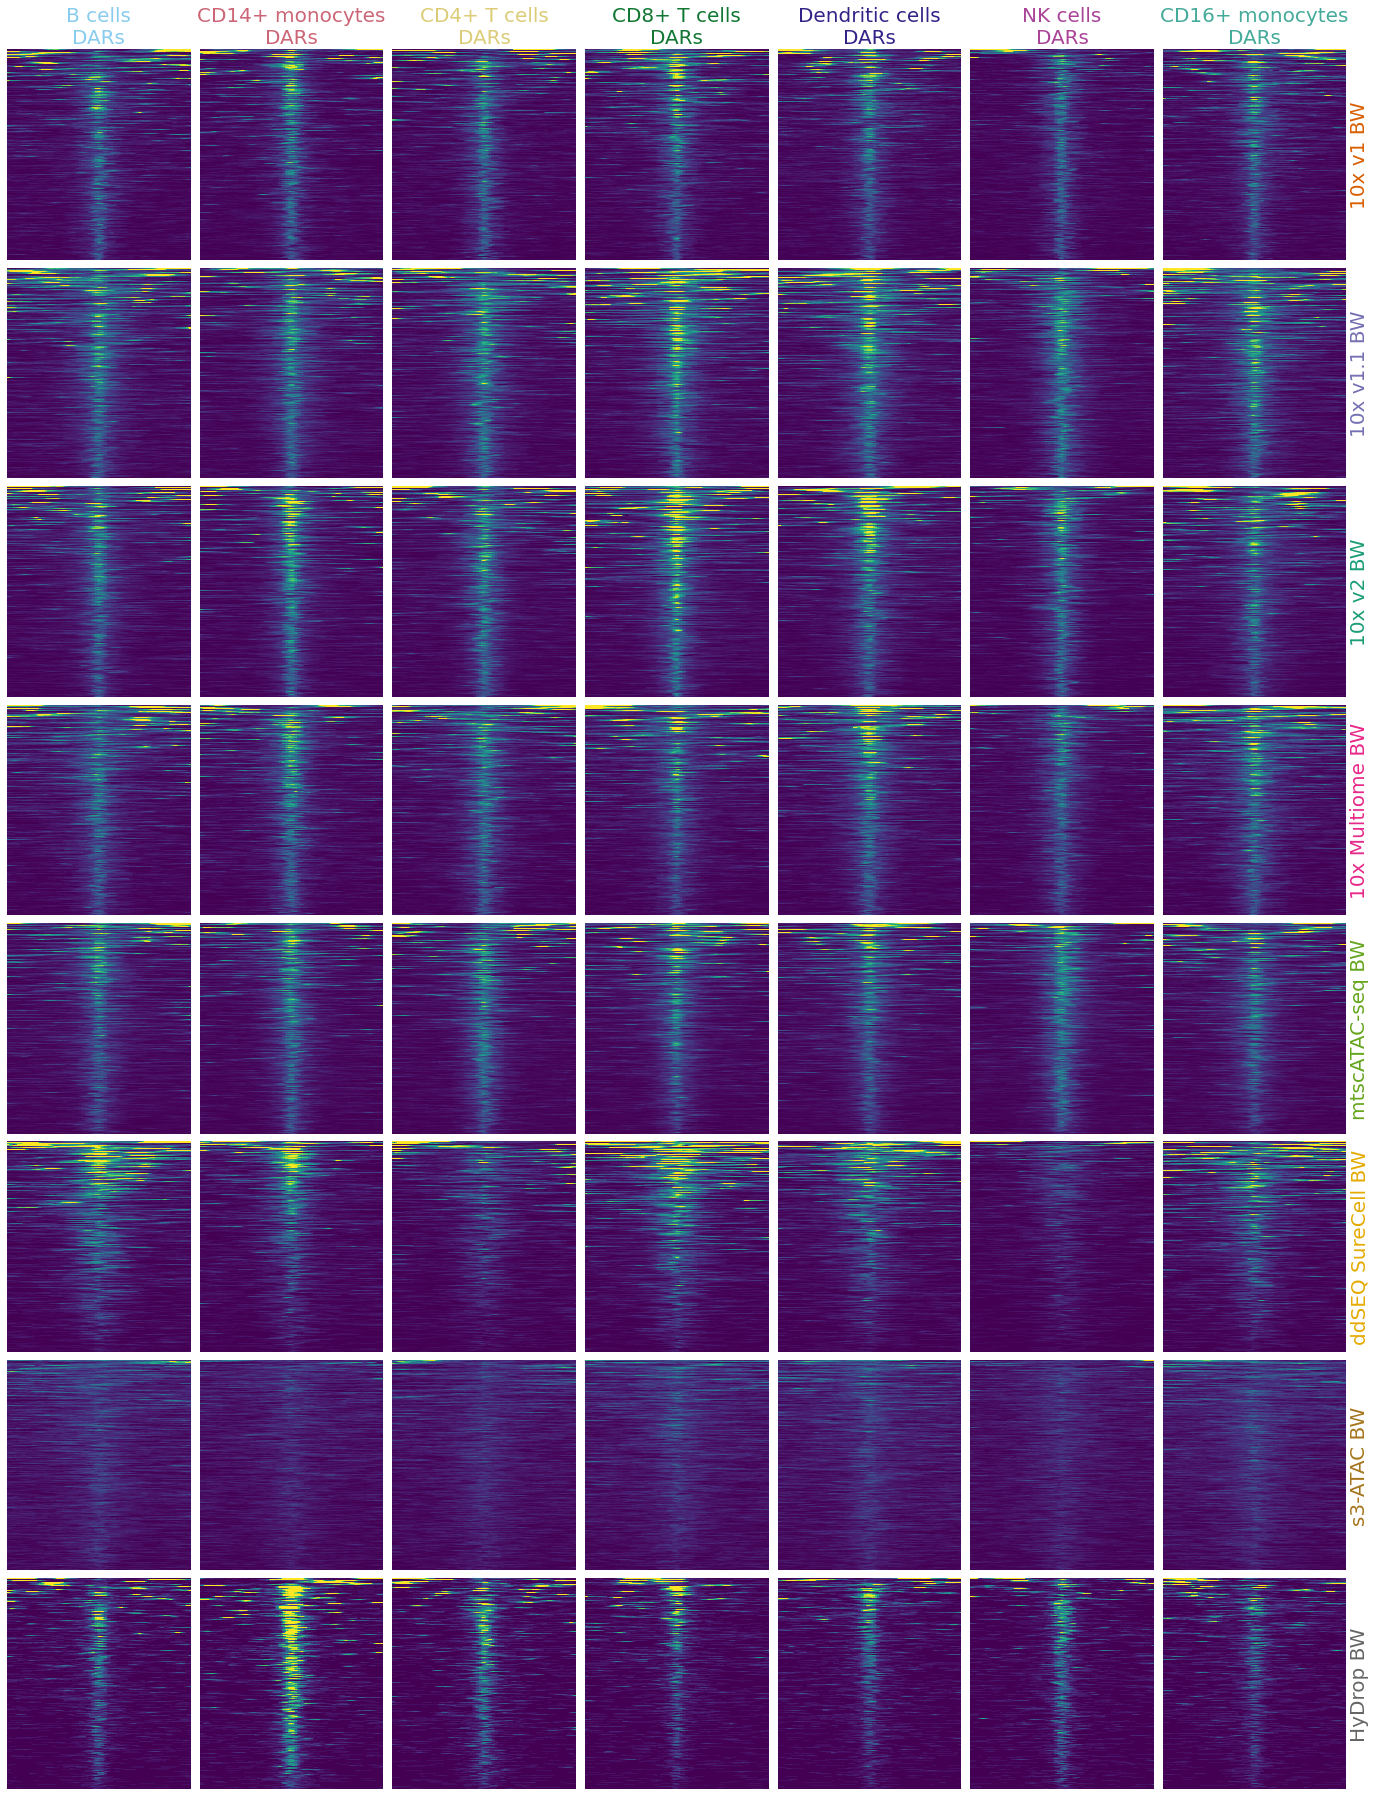

In [66]:
figure

# now instead of with general bigwigs, plot with tech-cell_type specific bigwigs

In [ ]:
def read_bw_values(bed_part, bw):
    bw = pyBigWig.open(bw)
    colnames = np.append(
        np.arange(-1250, 0), np.arange(0, 1250)
    )  # colnames are a range over the interval that we look at
    df = pd.DataFrame(columns=colnames)
    for line in bed_part.iterrows():
        vals = bw.values(
            line[1][0],
            int(line[1][1]) - interval_downstream,
            int(line[1][2]) + interval_upstream,
        )
        df.loc[line[0]] = vals

    return df

In [ ]:
max_dict = {}
interval_downstream = 1000
interval_upstream = 1000
binsize = 20
top_n = 2000
cores = 24

In [ ]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_")[1:]).split(".")[0]
            for x in glob.glob(
                "per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*"
            )
        ]
    )
)

bw_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    bw_path_dict_dict[cell_type] = {
        x.split("/")[-1].split("_")[0]: x
        for x in glob.glob(
            f"per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*{cell_type}*"
        )
    }
bw_path_dict_dict

In [ ]:
bed_path_dict = {
    "Cytotoxic_T_cell": "downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed",
    "CD14_monocyte": "downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD14+_monocyte__DARs.TOP2k.bed",
    "B_cell": "downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__B_cell__DARs.TOP2k.bed",
    "CD16_monocyte": "downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD16+_monocyte__DARs.TOP2k.bed",
    "Dendritic_cell": "downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Dendritic_cell__DARs.TOP2k.bed",
    "Natural_killer_cell": "downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed",
    "CD4_T_cell": "downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD4+_T_cell__DARs.TOP2k.bed",
}

In [ ]:
bw

In [ ]:
def read_bw_values(bed_part, bw):
    bw = pyBigWig.open(bw)
    colnames = np.append(
        np.arange(-1250, 0), np.arange(0, 1250)
    )  # colnames are a range over the interval that we look at
    df = pd.DataFrame(columns=colnames)

    for line in bed_part.iterrows():
        try:
            vals = bw.values(
                line[1][0],
                int(line[1][1]) - interval_downstream,
                int(line[1][2]) + interval_upstream,
            )
            df.loc[line[0]] = vals
        except:
            # vals = None
            vals = list(np.zeros(2500))

    return df

In [23]:
cores = 8

In [24]:
count_mats_bool = True
if count_mats_bool == True:
    for sample in list(bed_path_dict.keys()):
        print(sample)
        print(bed_path_dict[sample])
        df_bed = pd.read_csv(bed_path_dict[sample], sep="\t", index_col=None)
        df_bed.columns = ["chr", "start", "stop", "name", "logFC", "strand", "pval"]
        # df_bed.set_index('name', inplace=True)
        # df_bed.index.name = None
        df_bed = df_bed[0:top_n]

        mat_dict = {}

        for key in bw_path_dict_dict[sample].keys():

            torun = np.array_split(df_bed, cores, axis=0)
            bw = bw_path_dict_dict[sample][key]
            print(f"\t{bw}")

            iterable = zip(
                torun, repeat(bw)
            )  # this is the KEY difference between this and previous module. we now iterate over all keys to do all bigwigs instead of keeping all bigwigs the same

            # Calculate
            pool = Pool(processes=cores)
            results = pool.starmap(read_bw_values, iterable)
            pool.close()
            pool.join()
            df = pd.concat(results)
            df_binned = df.groupby(np.arange(len(df.columns)) // binsize, axis=1).mean()
            df_binned_nonan = df_binned.fillna(0)
            order = df_binned_nonan.mean(axis=1).sort_values(
                ascending=False
            )  # now reorder based in maximum mean
            df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

            mat_dict[key] = df_binned_nonan_ordered

        save_object(
            mat_dict,
            "per_tech_cell_type_bigwigs/"
            + sample
            + "_DARs_binsize"
            + str(binsize)
            + "_coveragemats_refined_logfcorder.pkl",
        )

        df_merged = pd.DataFrame(columns=range(0, len(mat_dict[key].columns)))
        for key in mat_dict.keys():
            df_merged = df_merged.append(mat_dict[key], ignore_index=False)

        quantiles = df_merged.quantile(
            q=0.99
        )  # for every base, calculate the quantile q value over all regions.
        maximum = (
            quantiles.max()
        )  # then, take the maxmum value out of these 250 values.
        print(
            maximum
        )  # the resulting maximum should give a cutoff that represents the 99th quantil of all values

        # alternatively, you can take a global quantile for the entire matrix (instead of per base)
        maximum = np.quantile(df_merged, 0.99)
        print(maximum)

        max_dict[sample] = maximum

        # f,ax = plt.subplots(1,len(sampleorder))
        # f.set_figheight(5)
        # f.set_figwidth(len(sampleorder)*3)

        # for key in sampleorder:
        #     g = sns.heatmap(mat_dict[key], cmap="viridis", cbar=False, ax=ax[sampleorder.index(key)], vmax=maximum, xticklabels=False, yticklabels=False)

        # save_object(f, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_f.pkl')
        # save_object(ax, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_ax.pkl')

    save_object(
        max_dict,
        "per_tech_cell_type_bigwigs/DARs_binsize"
        + str(binsize)
        + "_max_dict_refined_logfcorder.pkl",
    )

Cytotoxic_T_cell
downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIX

In [25]:
top_n = 2000

binsize = 20
filenames = sorted(
    glob.glob(
        "per_tech_cell_type_bigwigs/*"
        + str(binsize)
        + "_coveragemats_refined_logfcorder.pkl"
    )
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_logfcorder.pkl", ""
    )
    for item in filenames
]
samples = [item.replace("per_tech_cell_type_bigwigs/", "") for item in samples]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'B_cell': 'per_tech_cell_type_bigwigs/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14_monocyte': 'per_tech_cell_type_bigwigs/CD14_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16_monocyte': 'per_tech_cell_type_bigwigs/CD16_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4_T_cell': 'per_tech_cell_type_bigwigs/CD4_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'per_tech_cell_type_bigwigs/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'per_tech_cell_type_bigwigs/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'per_tech_cell_type_bigwigs/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

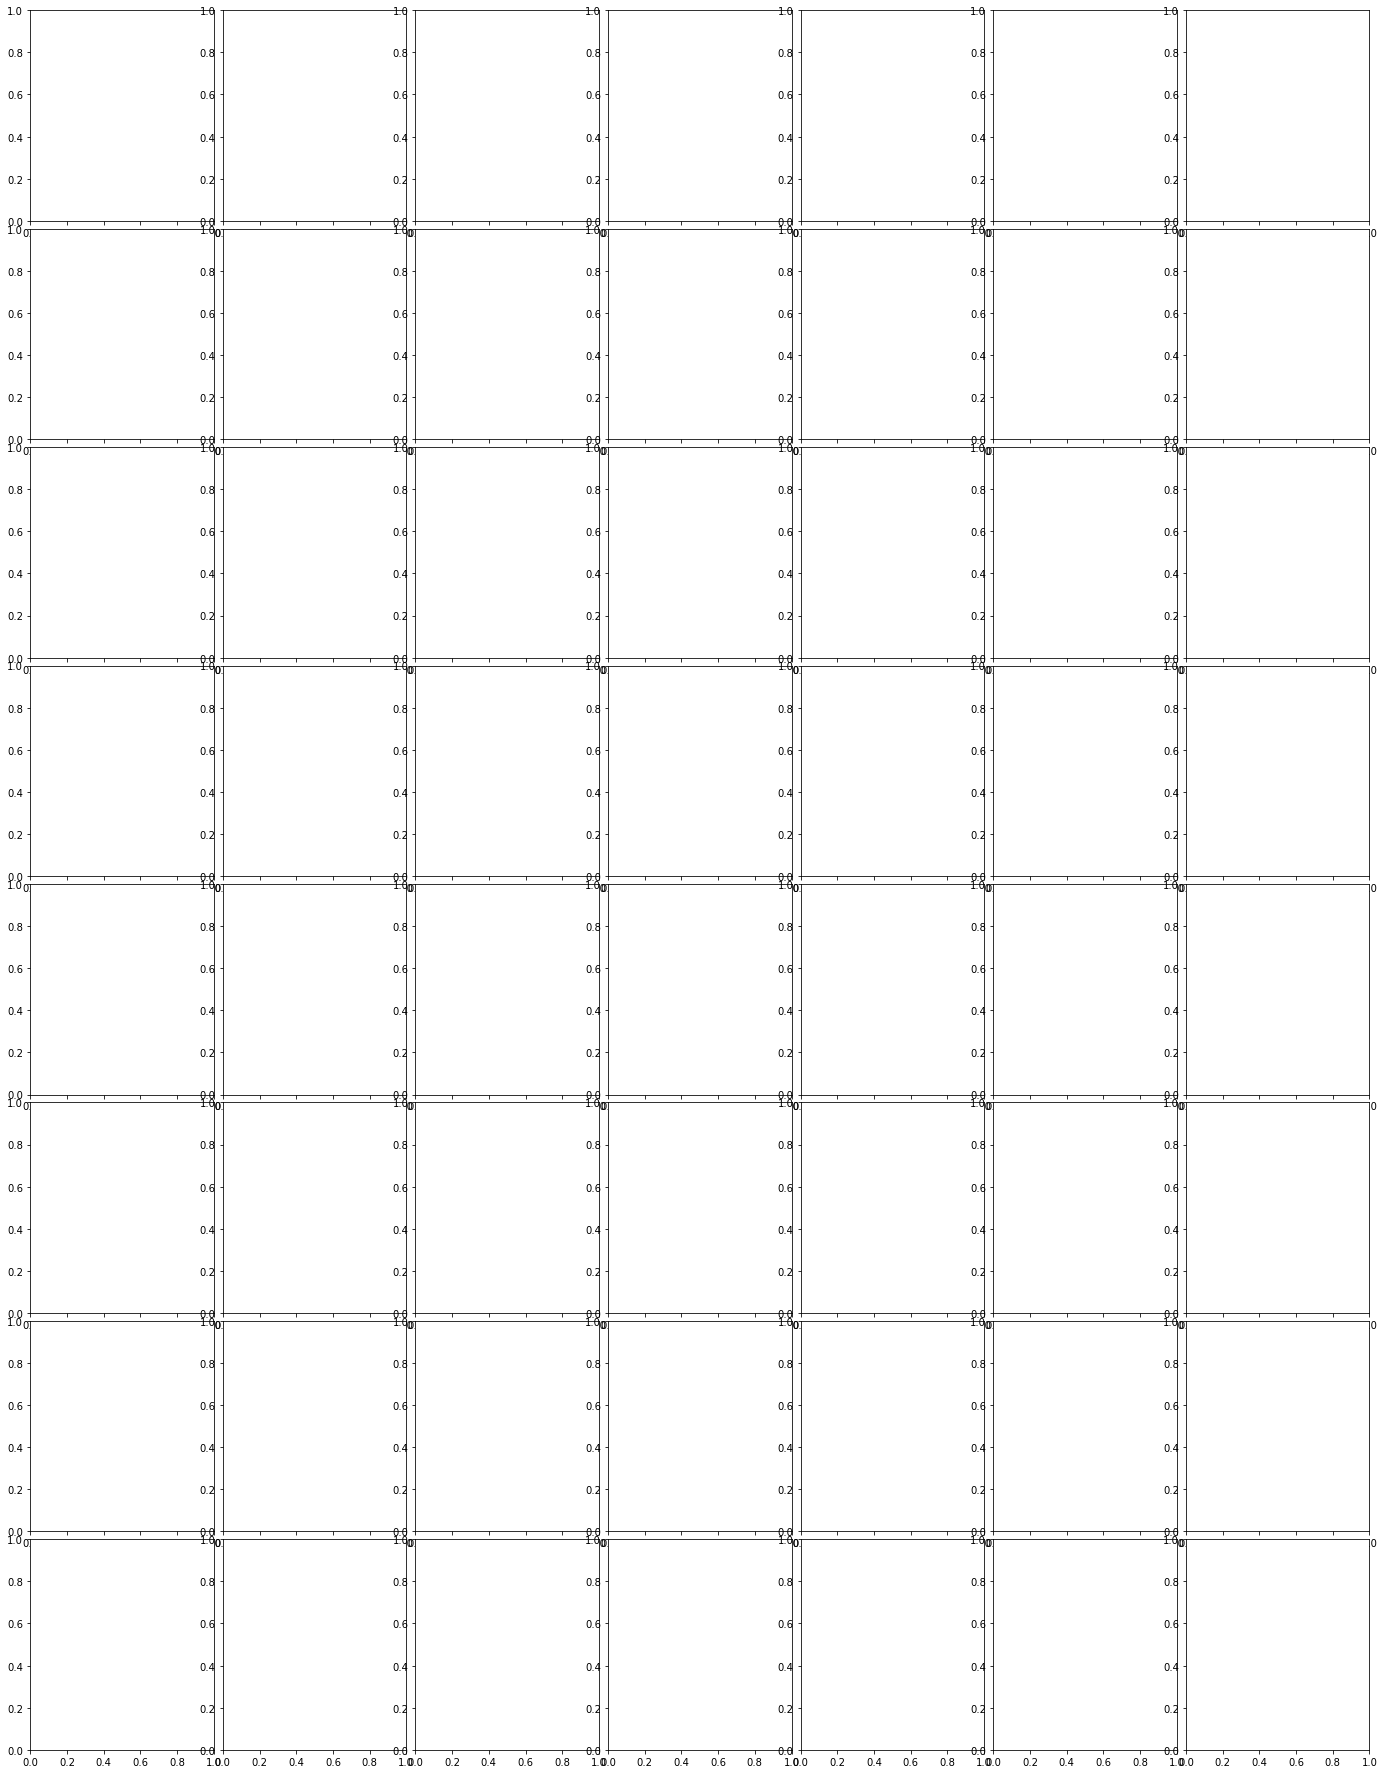

In [28]:
final_sampleorder = tech_order

height = len(final_sampleorder) * 4
width = len(final_sampleorder) * 3
figure, axes = plt.subplots(len(final_sampleorder), len(coveragemats_dict.keys()))

figure.set_figheight(height)
figure.set_figwidth(width)
figure.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05 / (4 / 3)
)

In [29]:
binsize = 20
filenames = sorted(
    glob.glob(
        "per_tech_cell_type_bigwigs/*"
        + str(binsize)
        + "_coveragemats_refined_logfcorder.pkl"
    )
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_logfcorder.pkl", ""
    )
    for item in filenames
]
samples = [item.replace("per_tech_cell_type_bigwigs/", "") for item in samples]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'B_cell': 'per_tech_cell_type_bigwigs/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14_monocyte': 'per_tech_cell_type_bigwigs/CD14_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16_monocyte': 'per_tech_cell_type_bigwigs/CD16_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4_T_cell': 'per_tech_cell_type_bigwigs/CD4_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'per_tech_cell_type_bigwigs/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'per_tech_cell_type_bigwigs/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'per_tech_cell_type_bigwigs/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

In [30]:
with open(
    f"per_tech_cell_type_bigwigs/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl",
    "rb",
) as f:
    max_dict = pickle.load(f)

mat_dict = {}
df_merged = pd.DataFrame()
for key in coveragemats_dict.keys():
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)
    for subkey in final_sampleorder:
        df_merged = df_merged.append(mat_dict[subkey], ignore_index=False)

maximum = np.quantile(df_merged, 0.99)
print(maximum)

loading B_cell...
loading CD14_monocyte...
loading CD16_monocyte...
loading CD4_T_cell...
loading Cytotoxic_T_cell...
loading Dendritic_cell...
loading Natural_killer_cell...
42.25


In [32]:
color_max = max(max_dict.values())
with open(
    f"per_tech_cell_type_bigwigs/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl",
    "rb",
) as f:
    max_dict = pickle.load(f)

for key in coveragemats_dict.keys():
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)
    for subkey in final_sampleorder:
        g = sns.heatmap(
            mat_dict[subkey][0:top_n],
            cmap="viridis",
            cbar=False,
            ax=axes[
                final_sampleorder.index(subkey),
                list(coveragemats_dict.keys()).index(key),
            ],
            vmax=color_max,
            xticklabels=False,
            yticklabels=False,
        )

    print(f"{key} processed!")

loading B_cell...
B_cell processed!
loading CD14_monocyte...
CD14_monocyte processed!
loading CD16_monocyte...
CD16_monocyte processed!
loading CD4_T_cell...
CD4_T_cell processed!
loading Cytotoxic_T_cell...
Cytotoxic_T_cell processed!
loading Dendritic_cell...
Dendritic_cell processed!
loading Natural_killer_cell...
Natural_killer_cell processed!


In [33]:
cell_type_alias_dict = {
    "B_cell": "B cells",
    "CD14_monocyte": "CD14+ monocytes",
    "CD4_T_cell": "CD4+ T cells",
    "Cytotoxic_T_cell": "CD8+ T cells",
    "Dendritic_cell": "Dendritic cells",
    "Natural_killer_cell": "NK cells",
    "CD16_monocyte": "CD16+ monocytes",
}

cell_type_order = [
    "B_cell",
    "CD14_monocyte",
    "CD4_T_cell",
    "Cytotoxic_T_cell",
    "Dendritic_cell",
    "Natural_killer_cell",
    "CD16_monocyte",
]

cell_type_color_dict = {
    "B_cell": "#88CCEE",
    "CD14_monocyte": "#CC6677",
    "CD4_T_cell": "#DDCC77",
    "Cytotoxic_T_cell": "#117733",
    "Dendritic_cell": "#332288",
    "Natural_killer_cell": "#AA4499",
    "CD16_monocyte": "#44AA99",
}

In [34]:
key

'Natural_killer_cell'

In [35]:
for key in coveragemats_dict.keys():
    axes[0, cell_type_order.index(key)].set_title(
        f"{cell_type_alias_dict[key]}\nDARs",
        fontsize=20,
        color=cell_type_color_dict[key],
    )
    print(f"{cell_type_alias_dict[key]} DARs")

B cells DARs
CD14+ monocytes DARs
CD16+ monocytes DARs
CD4+ T cells DARs
CD8+ T cells DARs
Dendritic cells DARs
NK cells DARs


In [36]:
for key in final_sampleorder:
    axes[final_sampleorder.index(key), -1].set_ylabel(
        f"{tech_alias_dict[key]} BW",
        fontsize=20,
        color=tech_color_palette[key],
    )
    axes[final_sampleorder.index(key), -1].yaxis.set_label_position("right")

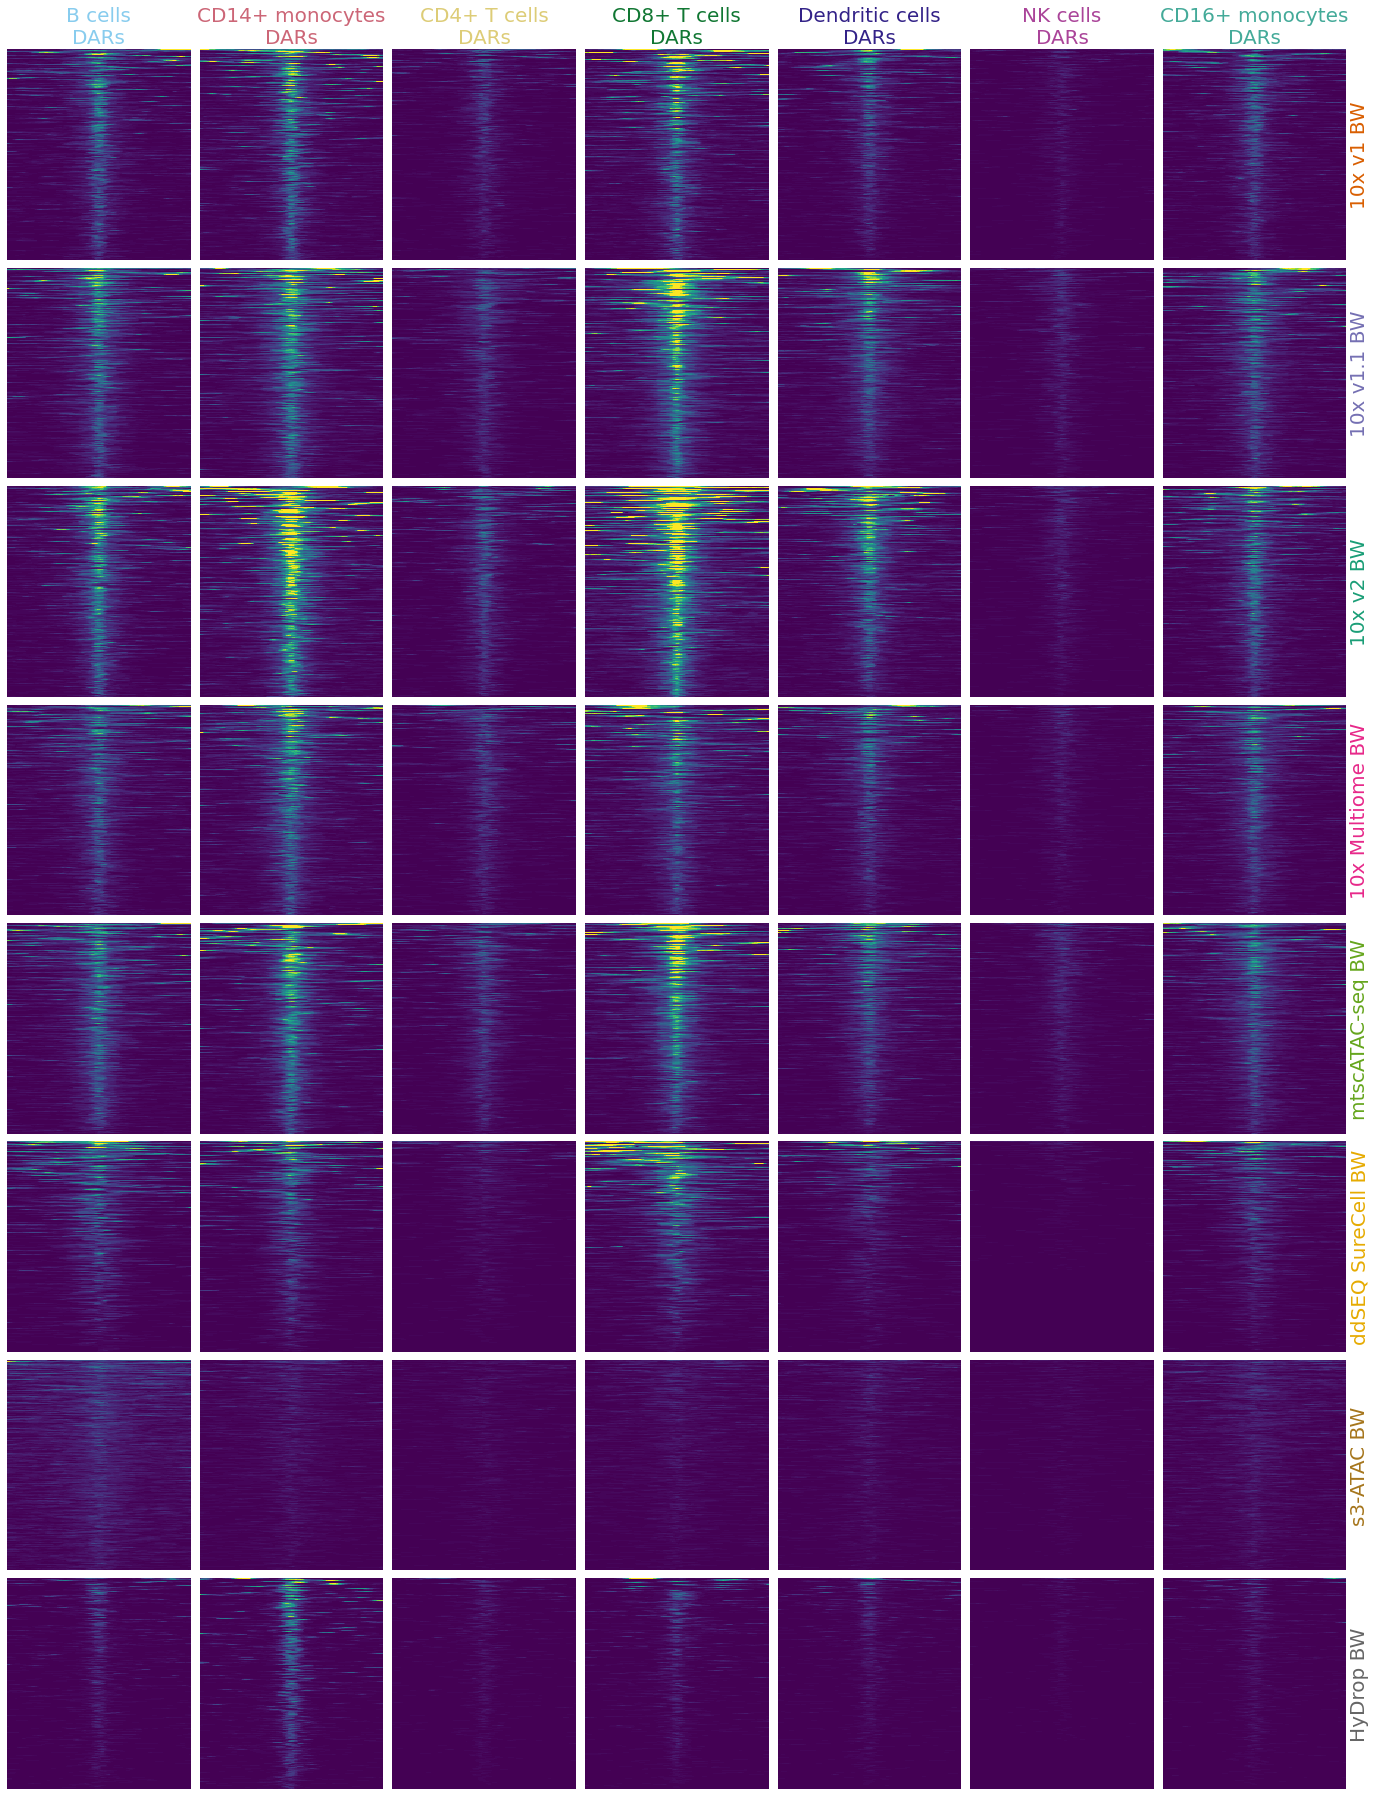

In [37]:
figure

In [38]:
figure.savefig("test.png")

# now, remake, but with harmony dars and non-normalized bigwigs

In [10]:
max_dict = {}
interval_downstream = 1000
interval_upstream = 1000
binsize = 20
top_n = 2000
cores = 24

In [11]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_")[1:]).split(".")[0]
            for x in glob.glob(
                "per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*"
            )
        ]
    )
)

bw_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    bw_path_dict_dict[cell_type] = {
        x.split("/")[-1].split("_")[0]: x
        for x in glob.glob(
            f"per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*{cell_type}*"
        )
    }
bw_path_dict_dict

{'Dendritic_cell': {'mtscatac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_Dendritic_cell.bw',
  '10xv2': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Dendritic_cell.bw',
  'ddseq': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_Dendritic_cell.bw',
  '10xv1': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_Dendritic_cell.bw',
  '10xmultiome': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_Dendritic_cell.bw',
  's3atac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Dendritic_cell.bw',
  '10xv11': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudob

In [12]:
bed_path_dict = {
    "Cytotoxic_T_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed",
    "CD14_monocyte": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD14+_monocyte__DARs.TOP2k.bed",
    "B_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__B_cell__DARs.TOP2k.bed",
    "CD16_monocyte": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD16+_monocyte__DARs.TOP2k.bed",
    "Dendritic_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Dendritic_cell__DARs.TOP2k.bed",
    "Natural_killer_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed",
    "CD4_T_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD4+_T_cell__DARs.TOP2k.bed",
}

In [13]:
def read_bw_values(bed_part, bw):
    bw = pyBigWig.open(bw)
    colnames = np.append(
        np.arange(-1250, 0), np.arange(0, 1250)
    )  # colnames are a range over the interval that we look at
    df = pd.DataFrame(columns=colnames)

    for line in bed_part.iterrows():
        try:
            vals = bw.values(
                line[1][0],
                int(line[1][1]) - interval_downstream,
                int(line[1][2]) + interval_upstream,
            )
            df.loc[line[0]] = vals
        except:
            # vals = None
            vals = list(np.zeros(2500))

    return df

In [14]:
count_mats_bool = True
if count_mats_bool == True:
    for sample in list(bed_path_dict.keys()):
        print(sample)
        print(bed_path_dict[sample])
        df_bed = pd.read_csv(bed_path_dict[sample], sep="\t", index_col=None)
        df_bed.columns = ["chr", "start", "stop", "name", "logFC", "strand", "pval"]
        # df_bed.set_index('name', inplace=True)
        # df_bed.index.name = None
        df_bed = df_bed[0:top_n]

        mat_dict = {}

        for key in bw_path_dict_dict[sample].keys():

            torun = np.array_split(df_bed, cores, axis=0)
            bw = bw_path_dict_dict[sample][key]
            print(f"\t{bw}")

            iterable = zip(
                torun, repeat(bw)
            )  # this is the KEY difference between this and previous module. we now iterate over all keys to do all bigwigs instead of keeping all bigwigs the same

            # Calculate
            pool = Pool(processes=cores)
            results = pool.starmap(read_bw_values, iterable)
            pool.close()
            pool.join()
            df = pd.concat(results)
            df_binned = df.groupby(np.arange(len(df.columns)) // binsize, axis=1).mean()
            df_binned_nonan = df_binned.fillna(0)
            order = df_binned_nonan.mean(axis=1).sort_values(
                ascending=False
            )  # now reorder based in maximum mean
            df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

            mat_dict[key] = df_binned_nonan_ordered

        save_object(
            mat_dict,
            "per_tech_harmony_cell_type_bigwigs_nonnorm/"
            + sample
            + "_DARs_binsize"
            + str(binsize)
            + "_coveragemats_refined_logfcorder.pkl",
        )

        df_merged = pd.DataFrame(columns=range(0, len(mat_dict[key].columns)))
        for key in mat_dict.keys():
            df_merged = df_merged.append(mat_dict[key], ignore_index=False)

        quantiles = df_merged.quantile(
            q=0.99
        )  # for every base, calculate the quantile q value over all regions.
        maximum = (
            quantiles.max()
        )  # then, take the maxmum value out of these 250 values.
        print(
            maximum
        )  # the resulting maximum should give a cutoff that represents the 99th quantil of all values

        # alternatively, you can take a global quantile for the entire matrix (instead of per base)
        maximum = np.quantile(df_merged, 0.99)
        print(maximum)

        max_dict[sample] = maximum

        # f,ax = plt.subplots(1,len(sampleorder))
        # f.set_figheight(5)
        # f.set_figwidth(len(sampleorder)*3)

        # for key in sampleorder:
        #     g = sns.heatmap(mat_dict[key], cmap="viridis", cbar=False, ax=ax[sampleorder.index(key)], vmax=maximum, xticklabels=False, yticklabels=False)

        # save_object(f, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_f.pkl')
        # save_object(ax, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_ax.pkl')

    save_object(
        max_dict,
        "per_tech_harmony_cell_type_bigwigs_nonnorm/DARs_binsize"
        + str(binsize)
        + "_max_dict_refined_logfcorder.pkl",
    )

Cytotoxic_T_cell
downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIX

In [15]:
top_n = 2000

binsize = 20
filenames = sorted(
    glob.glob(
        "per_tech_harmony_cell_type_bigwigs_nonnorm/*"
        + str(binsize)
        + "_coveragemats_refined_logfcorder.pkl"
    )
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_logfcorder.pkl", ""
    )
    for item in filenames
]
samples = [
    item.replace("per_tech_harmony_cell_type_bigwigs_nonnorm/", "") for item in samples
]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'B_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD14_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD16_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD4_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

In [16]:
binsize = 20
filenames = sorted(
    glob.glob(
        "per_tech_harmony_cell_type_bigwigs_nonnorm/*"
        + str(binsize)
        + "_coveragemats_refined_logfcorder.pkl"
    )
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_logfcorder.pkl", ""
    )
    for item in filenames
]
samples = [
    item.replace("per_tech_harmony_cell_type_bigwigs_nonnorm/", "") for item in samples
]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'B_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/B_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD14_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD14_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD16_monocyte': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD16_monocyte_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'CD4_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD4_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Cytotoxic_T_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Dendritic_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Dendritic_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl',
 'Natural_killer_cell': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Natural_killer_cell_DARs_binsize20_coveragemats_refined_logfcorder.pkl'}

In [18]:
final_sampleorder = tech_order

In [19]:
with open(
    f"per_tech_harmony_cell_type_bigwigs_nonnorm/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl",
    "rb",
) as f:
    max_dict = pickle.load(f)

mat_dict = {}
df_merged = pd.DataFrame()
for key in coveragemats_dict.keys():
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)
    for subkey in final_sampleorder:
        df_merged = df_merged.append(mat_dict[subkey], ignore_index=False)

maximum = np.quantile(df_merged, 0.99)
print(maximum)

loading B_cell...
loading CD14_monocyte...
loading CD16_monocyte...
loading CD4_T_cell...
loading Cytotoxic_T_cell...
loading Dendritic_cell...
loading Natural_killer_cell...
42.25


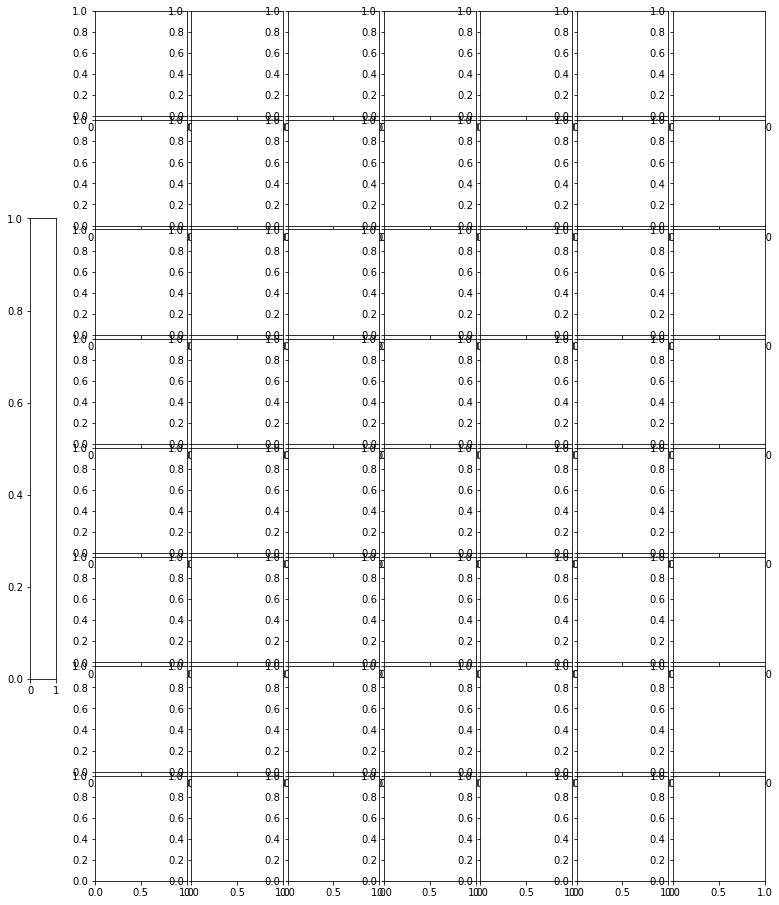

In [20]:
final_sampleorder = tech_order

height = len(final_sampleorder) * 2
width = len(final_sampleorder) * 1.5
figure, axes = plt.subplots(len(final_sampleorder), len(coveragemats_dict.keys()))

figure.set_figheight(height)
figure.set_figwidth(width)
figure.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05 / (4 / 3)
)

cbar_ax = figure.add_axes([0.05, 0.3, 0.03, 0.4])

In [ ]:
color_max = max(max_dict.values())
with open(
    f"per_tech_harmony_cell_type_bigwigs_nonnorm/DARs_binsize{str(binsize)}_max_dict_refined_logfcorder.pkl",
    "rb",
) as f:
    max_dict = pickle.load(f)

for key in coveragemats_dict.keys():
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)
    for subkey in final_sampleorder:
        g = sns.heatmap(
            mat_dict[subkey][0:top_n],
            cmap="viridis",
            cbar=True,
            cbar_ax=cbar_ax,
            ax=axes[
                final_sampleorder.index(subkey),
                list(coveragemats_dict.keys()).index(key),
            ],
            vmax=color_max,
            xticklabels=False,
            yticklabels=False,
        )

    print(f"{key} processed!")

loading B_cell...
B_cell processed!
loading CD14_monocyte...
CD14_monocyte processed!
loading CD16_monocyte...
CD16_monocyte processed!
loading CD4_T_cell...
CD4_T_cell processed!
loading Cytotoxic_T_cell...
Cytotoxic_T_cell processed!
loading Dendritic_cell...
Dendritic_cell processed!
loading Natural_killer_cell...
Natural_killer_cell processed!


In [22]:
cell_type_alias_dict = {
    "B_cell": "B cell",
    "CD14_monocyte": "CD14+\nmonocytes",
    "CD4_T_cell": "CD4+ T\ncells",
    "Cytotoxic_T_cell": "CD8+ T\ncells",
    "Dendritic_cell": "Dendritic\ncells",
    "Natural_killer_cell": "NK cells",
    "CD16_monocyte": "CD16+\nmonocytes",
}

cell_type_order = [
    "B_cell",
    "CD14_monocyte",
    "CD4_T_cell",
    "Cytotoxic_T_cell",
    "Dendritic_cell",
    "Natural_killer_cell",
    "CD16_monocyte",
]

cell_type_color_dict = {
    "B_cell": "#88CCEE",
    "CD14_monocyte": "#CC6677",
    "CD4_T_cell": "#DDCC77",
    "Cytotoxic_T_cell": "#117733",
    "Dendritic_cell": "#332288",
    "Natural_killer_cell": "#AA4499",
    "CD16_monocyte": "#44AA99",
}

In [23]:
for key in coveragemats_dict.keys():
    axes[0, cell_type_order.index(key)].set_title(
        f"{cell_type_alias_dict[key]}",
        fontsize=16,
        color=cell_type_color_dict[key],
    )
    print(f"{cell_type_alias_dict[key]} DARs")

B cell DARs
CD14+
monocytes DARs
CD16+
monocytes DARs
CD4+ T
cells DARs
CD8+ T
cells DARs
Dendritic
cells DARs
NK cells DARs


In [24]:
for key in final_sampleorder:
    axes[final_sampleorder.index(key), -1].set_ylabel(
        f"{tech_alias_dict[key]}",
        fontsize=16,
        color=tech_color_palette[key],
        rotation=0,
        ha="left",
    )
    axes[final_sampleorder.index(key), -1].yaxis.set_label_position("right")

In [25]:
figure.savefig(
    "plts_track/dar_carrot__per_tech_harmony_cell_type_bigwigs_nonnorm.png",
    facecolor="white",
    dpi=100,
    bbox_inches="tight",
)
figure.savefig(
    "plts_track/dar_carrot__per_tech_harmony_cell_type_bigwigs_nonnorm.tiff",
    facecolor="white",
    dpi=100,
    bbox_inches="tight",
)

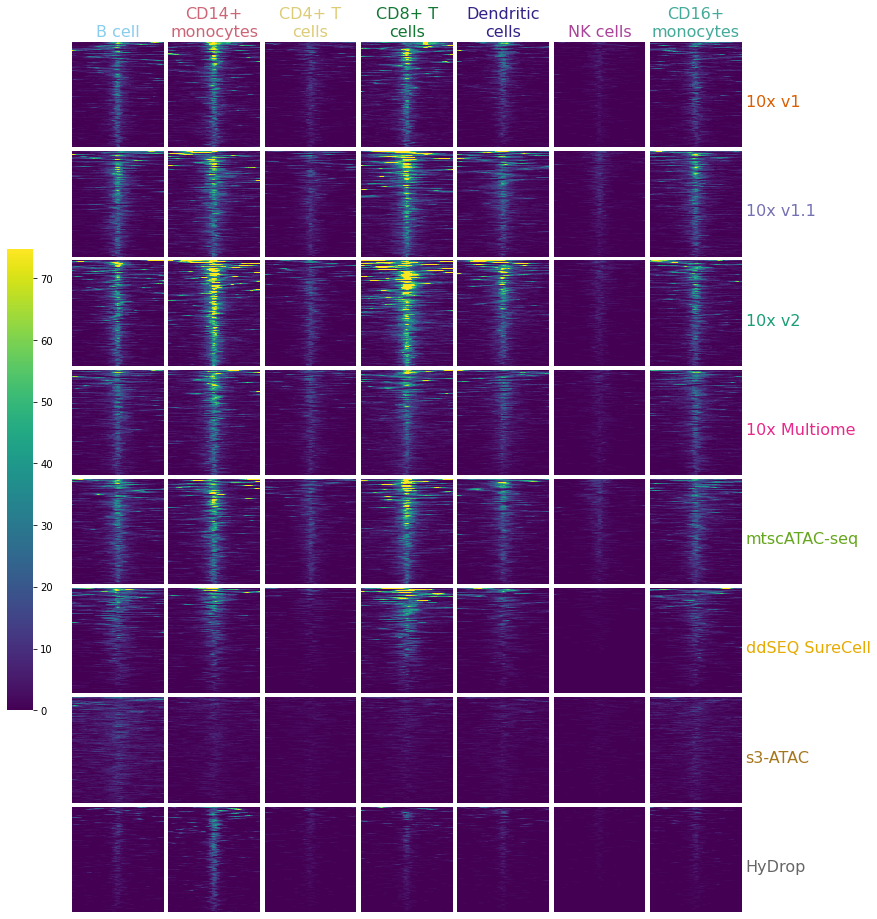

In [26]:
figure

# use this data to select a DAR that has the highest mean rank to plot

In [28]:
bed_path_dict = {
    "Cytotoxic_T_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed",
    "CD14_monocyte": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD14+_monocyte__DARs.TOP2k.bed",
    "B_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__B_cell__DARs.TOP2k.bed",
    "CD16_monocyte": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD16+_monocyte__DARs.TOP2k.bed",
    "Dendritic_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Dendritic_cell__DARs.TOP2k.bed",
    "Natural_killer_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed",
    "CD4_T_cell": "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD4+_T_cell__DARs.TOP2k.bed",
}

In [29]:
def read_bw_values(bed_part, bw):
    bw = pyBigWig.open(bw)
    colnames = np.append(
        np.arange(-1250, 0), np.arange(0, 1250)
    )  # colnames are a range over the interval that we look at
    df = pd.DataFrame(columns=colnames)

    for line in bed_part.iterrows():
        try:
            vals = bw.values(
                line[1][0],
                int(line[1][1]) - interval_downstream,
                int(line[1][2]) + interval_upstream,
            )
            df.loc[line[0]] = vals
        except:
            # vals = None
            vals = list(np.zeros(2500))

    return df

In [30]:
bw_path_dict_dict

{'Dendritic_cell': {'mtscatac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_Dendritic_cell.bw',
  '10xv2': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Dendritic_cell.bw',
  'ddseq': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_Dendritic_cell.bw',
  '10xv1': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_Dendritic_cell.bw',
  '10xmultiome': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_Dendritic_cell.bw',
  's3atac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Dendritic_cell.bw',
  '10xv11': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudob

In [31]:
count_mats_bool = True
if count_mats_bool == True:
    for sample in list(bed_path_dict.keys()):
        print(sample)
        print(bed_path_dict[sample])
        df_bed = pd.read_csv(bed_path_dict[sample], sep="\t", index_col=None)
        df_bed.columns = ["chr", "start", "stop", "name", "logFC", "strand", "pval"]
        # df_bed.set_index('name', inplace=True)
        # df_bed.index.name = None
        df_bed = df_bed[0:top_n]

        mat_dict = {}

        for key in bw_path_dict_dict[sample].keys():

            torun = np.array_split(df_bed, cores, axis=0)
            bw = bw_path_dict_dict[sample][key]
            print(f"\t{bw}")

            iterable = zip(
                torun, repeat(bw)
            )  # this is the KEY difference between this and previous module. we now iterate over all keys to do all bigwigs instead of keeping all bigwigs the same

            # Calculate
            pool = Pool(processes=cores)
            results = pool.starmap(read_bw_values, iterable)
            pool.close()
            pool.join()
            df = pd.concat(results)
            df_binned = df.groupby(np.arange(len(df.columns)) // binsize, axis=1).mean()
            df_binned_nonan = df_binned.fillna(0)
            order = df_binned_nonan.mean(axis=1).sort_values(
                ascending=False
            )  # now reorder based in maximum mean
            df_binned_nonan_ordered = df_binned_nonan.reindex(order.index)

            mat_dict[key] = df_binned_nonan

        save_object(
            mat_dict,
            "per_tech_harmony_cell_type_bigwigs_nonnorm/"
            + sample
            + "_DARs_binsize"
            + str(binsize)
            + "_coveragemats_refined_darcorder.pkl",
        )

        df_merged = pd.DataFrame(columns=range(0, len(mat_dict[key].columns)))
        for key in mat_dict.keys():
            df_merged = df_merged.append(mat_dict[key], ignore_index=False)

        quantiles = df_merged.quantile(
            q=0.99
        )  # for every base, calculate the quantile q value over all regions.
        maximum = (
            quantiles.max()
        )  # then, take the maxmum value out of these 250 values.
        print(
            maximum
        )  # the resulting maximum should give a cutoff that represents the 99th quantil of all values

        # alternatively, you can take a global quantile for the entire matrix (instead of per base)
        maximum = np.quantile(df_merged, 0.99)
        print(maximum)

        max_dict[sample] = maximum

        # f,ax = plt.subplots(1,len(sampleorder))
        # f.set_figheight(5)
        # f.set_figwidth(len(sampleorder)*3)

        # for key in sampleorder:
        #     g = sns.heatmap(mat_dict[key], cmap="viridis", cbar=False, ax=ax[sampleorder.index(key)], vmax=maximum, xticklabels=False, yticklabels=False)

        # save_object(f, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_f.pkl')
        # save_object(ax, 'heatmap_mats/'+sample+'_DARs_binsize'+str(binsize)+'_top'+str(top_n)+'_ax.pkl')

    save_object(
        max_dict,
        "per_tech_harmony_cell_type_bigwigs_nonnorm/DARs_binsize"
        + str(binsize)
        + "_max_dict_refined_darorder.pkl",
    )

Cytotoxic_T_cell
downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_Cytotoxic_T_cell.bw
	per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIX

In [40]:
binsize = 20
filenames = sorted(
    glob.glob(
        "per_tech_harmony_cell_type_bigwigs_nonnorm/*"
        + str(binsize)
        + "_coveragemats_refined_darorder.pkl"
    )
)
samples = [
    item.replace(
        "_DARs_binsize" + str(binsize) + "_coveragemats_refined_c\darorder.pkl", ""
    )
    for item in filenames
]
samples = [
    item.replace("per_tech_harmony_cell_type_bigwigs_nonnorm/", "") for item in samples
]
coveragemats_dict = {samples[i]: filenames[i] for i in range(len(samples))}
coveragemats_dict

{'B_cell_DARs_binsize20_coveragemats_refined_darorder.pkl': 'per_tech_harmony_cell_type_bigwigs_nonnorm/B_cell_DARs_binsize20_coveragemats_refined_darorder.pkl',
 'CD14_monocyte_DARs_binsize20_coveragemats_refined_darorder.pkl': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD14_monocyte_DARs_binsize20_coveragemats_refined_darorder.pkl',
 'CD16_monocyte_DARs_binsize20_coveragemats_refined_darorder.pkl': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD16_monocyte_DARs_binsize20_coveragemats_refined_darorder.pkl',
 'CD4_T_cell_DARs_binsize20_coveragemats_refined_darorder.pkl': 'per_tech_harmony_cell_type_bigwigs_nonnorm/CD4_T_cell_DARs_binsize20_coveragemats_refined_darorder.pkl',
 'Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_darorder.pkl': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_darorder.pkl',
 'Dendritic_cell_DARs_binsize20_coveragemats_refined_darorder.pkl': 'per_tech_harmony_cell_type_bigwigs_nonnorm/Dendritic_cell_DARs_bi

In [45]:
import scipy.stats as ss

In [47]:
ss.rankdata(df_binned_nonan.mean(axis=1))

array([1294. ,   66.5,  366.5, ...,  399. ,  328. , 1770. ])

In [49]:
ranks_df_dict = {}
for key in coveragemats_dict.keys():
    with open(coveragemats_dict[key], "rb") as f:
        print(f"loading {key}...")
        mat_dict = pickle.load(f)

    df_ranks = pd.DataFrame()
    for subkey in final_sampleorder:
        print(f"\t{subkey}")
        df_binned_nonan = mat_dict[subkey][0:top_n]
        # order = df_binned_nonan.mean(axis=1).sort_values(
        #     ascending=False
        # )  # now reorder based in maximum mean
        rank = ss.rankdata(df_binned_nonan.mean(axis=1))

        df_ranks[subkey] = rank

    ranks_df_dict[key] = df_ranks
    print(f"{key} processed!")

loading B_cell_DARs_binsize20_coveragemats_refined_darorder.pkl...
	10xv1
	10xv11
	10xv2
	10xmultiome
	mtscatac
	ddseq
	s3atac
	hydrop
B_cell_DARs_binsize20_coveragemats_refined_darorder.pkl processed!
loading CD14_monocyte_DARs_binsize20_coveragemats_refined_darorder.pkl...
	10xv1
	10xv11
	10xv2
	10xmultiome
	mtscatac
	ddseq
	s3atac
	hydrop
CD14_monocyte_DARs_binsize20_coveragemats_refined_darorder.pkl processed!
loading CD16_monocyte_DARs_binsize20_coveragemats_refined_darorder.pkl...
	10xv1
	10xv11
	10xv2
	10xmultiome
	mtscatac
	ddseq
	s3atac
	hydrop
CD16_monocyte_DARs_binsize20_coveragemats_refined_darorder.pkl processed!
loading CD4_T_cell_DARs_binsize20_coveragemats_refined_darorder.pkl...
	10xv1
	10xv11
	10xv2
	10xmultiome
	mtscatac
	ddseq
	s3atac
	hydrop
CD4_T_cell_DARs_binsize20_coveragemats_refined_darorder.pkl processed!
loading Cytotoxic_T_cell_DARs_binsize20_coveragemats_refined_darorder.pkl...
	10xv1
	10xv11
	10xv2
	10xmultiome
	mtscatac
	ddseq
	s3atac
	hydrop
Cytotoxic_T

In [62]:
bed_path_dict

{'Cytotoxic_T_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed',
 'CD14_monocyte': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD14+_monocyte__DARs.TOP2k.bed',
 'B_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__B_cell__DARs.TOP2k.bed',
 'CD16_monocyte': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD16+_monocyte__DARs.TOP2k.bed',
 'Dendritic_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Dendritic_cell__DARs.TOP2k.bed',
 'Natural_killer_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed',
 'CD4_T_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD4+_T_cell__DARs.TOP2k.bed'}

In [78]:
df_ranks

10xv1  10xv11   10xv2  10xmultiome  mtscatac   ddseq  s3atac  hydrop
0      531.0   527.0   448.0        683.0     363.0   963.0   700.0  1294.0
1      167.5   226.0   313.0         82.0     464.0   143.0   364.0    66.5
2      802.0   805.0   798.0        764.0     360.0   217.0  1056.0   366.5
3      460.0   282.0   656.0        537.0     272.0  1105.0   417.0   258.5
4     1985.0  1982.0  1990.0       1985.0    1965.0  1988.0  1963.0  1963.0
...      ...     ...     ...          ...       ...     ...     ...     ...
1994   251.0   245.0   302.0        285.0     303.0   695.0   214.0   631.5
1995   669.0   802.0   758.0       1135.0     422.0  1603.0  1116.0  1439.0
1996  1012.0   822.0   795.0        460.0    1484.0  1161.0   309.0   399.0
1997   537.5   168.0   344.0        281.0     133.0   368.0   916.0   328.0
1998  1929.0  1763.0  1853.0       1956.0    1762.0  1994.0  1283.0  1770.0

[1999 rows x 8 columns]

In [79]:
10x_ranks

SyntaxError: invalid syntax (<ipython-input-79-a9827b79903f>, line 1)

ERROR:root:Cannot parse: 1:2: 10x_ranks
Traceback (most recent call last):
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/black/__init__.py", line 974, in format_str
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/black/__init__.py", line 1083, in lib2to3_parse
    raise exc from None
black.InvalidInput: Cannot parse: 1:2: 10x_ranks


In [77]:
df_ranks["10xv1 10xv11 10xv2 10xmultiome mtscatac".split()]

10xv1  10xv11   10xv2  10xmultiome  mtscatac
0      531.0   527.0   448.0        683.0     363.0
1      167.5   226.0   313.0         82.0     464.0
2      802.0   805.0   798.0        764.0     360.0
3      460.0   282.0   656.0        537.0     272.0
4     1985.0  1982.0  1990.0       1985.0    1965.0
...      ...     ...     ...          ...       ...
1994   251.0   245.0   302.0        285.0     303.0
1995   669.0   802.0   758.0       1135.0     422.0
1996  1012.0   822.0   795.0        460.0    1484.0
1997   537.5   168.0   344.0        281.0     133.0
1998  1929.0  1763.0  1853.0       1956.0    1762.0

[1999 rows x 5 columns]

In [85]:
df_ranks

10xv1  10xv11   10xv2  10xmultiome  mtscatac   ddseq  s3atac  hydrop
0      531.0   527.0   448.0        683.0     363.0   963.0   700.0  1294.0
1      167.5   226.0   313.0         82.0     464.0   143.0   364.0    66.5
2      802.0   805.0   798.0        764.0     360.0   217.0  1056.0   366.5
3      460.0   282.0   656.0        537.0     272.0  1105.0   417.0   258.5
4     1985.0  1982.0  1990.0       1985.0    1965.0  1988.0  1963.0  1963.0
...      ...     ...     ...          ...       ...     ...     ...     ...
1994   251.0   245.0   302.0        285.0     303.0   695.0   214.0   631.5
1995   669.0   802.0   758.0       1135.0     422.0  1603.0  1116.0  1439.0
1996  1012.0   822.0   795.0        460.0    1484.0  1161.0   309.0   399.0
1997   537.5   168.0   344.0        281.0     133.0   368.0   916.0   328.0
1998  1929.0  1763.0  1853.0       1956.0    1762.0  1994.0  1283.0  1770.0

[1999 rows x 8 columns]

In [90]:
df_normalized

ddseq  s3atac  hydrop     txg
0      963.0   700.0  1294.0   527.0
1      143.0   364.0    66.5   226.0
2      217.0  1056.0   366.5   798.0
3     1105.0   417.0   258.5   460.0
4     1988.0  1963.0  1963.0  1985.0
...      ...     ...     ...     ...
1994   695.0   214.0   631.5   285.0
1995  1603.0  1116.0  1439.0   758.0
1996  1161.0   309.0   399.0   822.0
1997   368.0   916.0   328.0   281.0
1998  1994.0  1283.0  1770.0  1853.0

[1999 rows x 4 columns]

In [92]:
best_dar_dict = {}
for cell_type, df_ranks in ranks_df_dict.items():
    cell_type = cell_type.split("_DARs")[0]

    txg_ranks = df_ranks["10xv1 10xv11 10xv2 10xmultiome mtscatac".split()].median(
        axis=1
    )
    df_normalized = df_ranks["ddseq s3atac hydrop".split()]
    df_normalized["txg"] = txg_ranks
    rank = df_normalized.median(axis=1).sort_values(ascending=True).index[0]

    df_bed = pd.read_csv(bed_path_dict[cell_type], sep="\t", index_col=None)
    df_bed.columns = ["chr", "start", "stop", "name", "logFC", "strand", "pval"]

    best_dar_dict[cell_type] = (
        df_bed.iloc[rank]["chr"]
        + ":"
        + str(df_bed.iloc[rank]["start"])
        + "-"
        + str(df_bed.iloc[rank]["stop"])
    )

/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [93]:
best_dar_dict

{'B_cell': 'chr9:105355788-105356288',
 'CD14_monocyte': 'chr13:73338358-73338858',
 'CD16_monocyte': 'chr2:127014597-127015097',
 'CD4_T_cell': 'chr13:26062788-26063288',
 'Cytotoxic_T_cell': 'chr21:44829703-44830203',
 'Dendritic_cell': 'chr6:72580326-72580826',
 'Natural_killer_cell': 'chr6:168968153-168968653'}

now plot that in dar_traces